In [5]:
import sys; sys.path.append('../../wwa'); from wwa import *

xn,xx,yn,yx = [-15,30,35,60]

In [6]:
# load daily data
da = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/EUR_heat/era5_t2m.nc").t2m
da = da.sel(lon = slice(xn,xx), lat = slice(yx,yn))

# da = convert_units_to(da, "degC")
da = (da - 273.15).assign_coords(units = "degC")

In [7]:
px = pd.read_csv("city_coords.csv", index_col = 0).dropna(axis = 0, how = "all").dropna(axis = 1, how = "all")

In [8]:
t_cities = {v["City name"] : da.sel(lon = v["lon"], lat = v["lat"], method = "nearest", drop = True) for k,v in px.iterrows()}

In [9]:
days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(len(days)) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(len(days)) if (days[i].day) == 15]

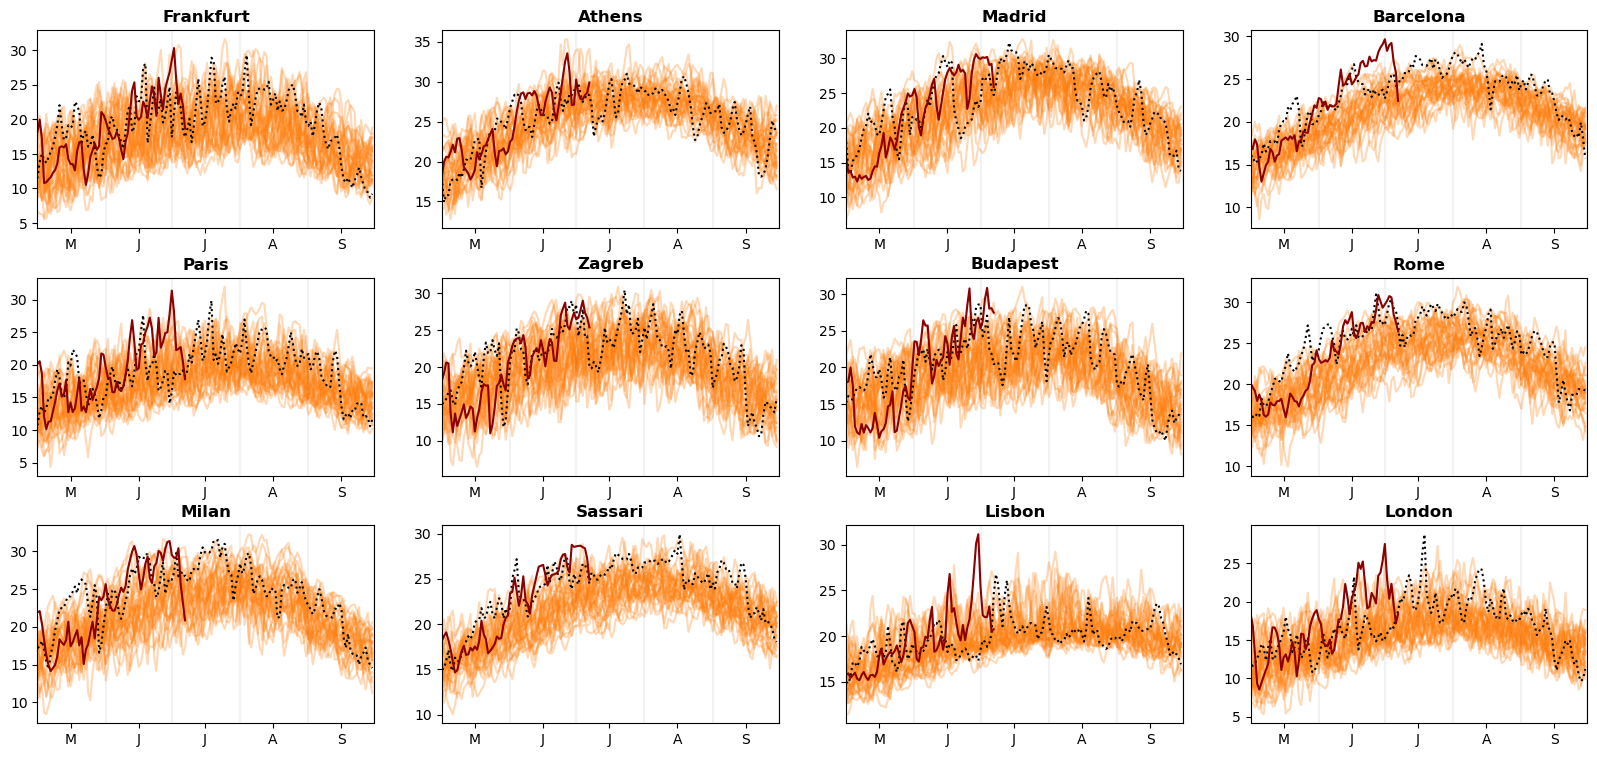

In [21]:
nc = 4; nr = 3
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 5, nr * 3), dpi = 100)
plt.subplots_adjust(hspace = 0.25)

for i in range(min(nc*nr, len(t_cities))):
    c = list(t_cities.keys())[i]
    ts = t_cities[c]
    ax = axs.flatten()[i]
    
    ts = ts.sel(time = ts.time.dt.dayofyear.isin(range(121,274)))
    
    for y in range(1990,2020):
        ts_y = ts.loc[str(y)]
        ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:orange", alpha = 0.3, label = "_years")
    
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(len(days)) if (days[x].day) == 1]
    
    ax.plot(ts.loc["2022"].time.dt.dayofyear, ts.loc["2022"], color = "k", ls = ":")
    ax.plot(ts.loc["2025"].time.dt.dayofyear, ts.loc["2025"], color = "darkred")
    ax.set_title(c, fontweight = "bold")
    
    ax.set_xlim(121,274)

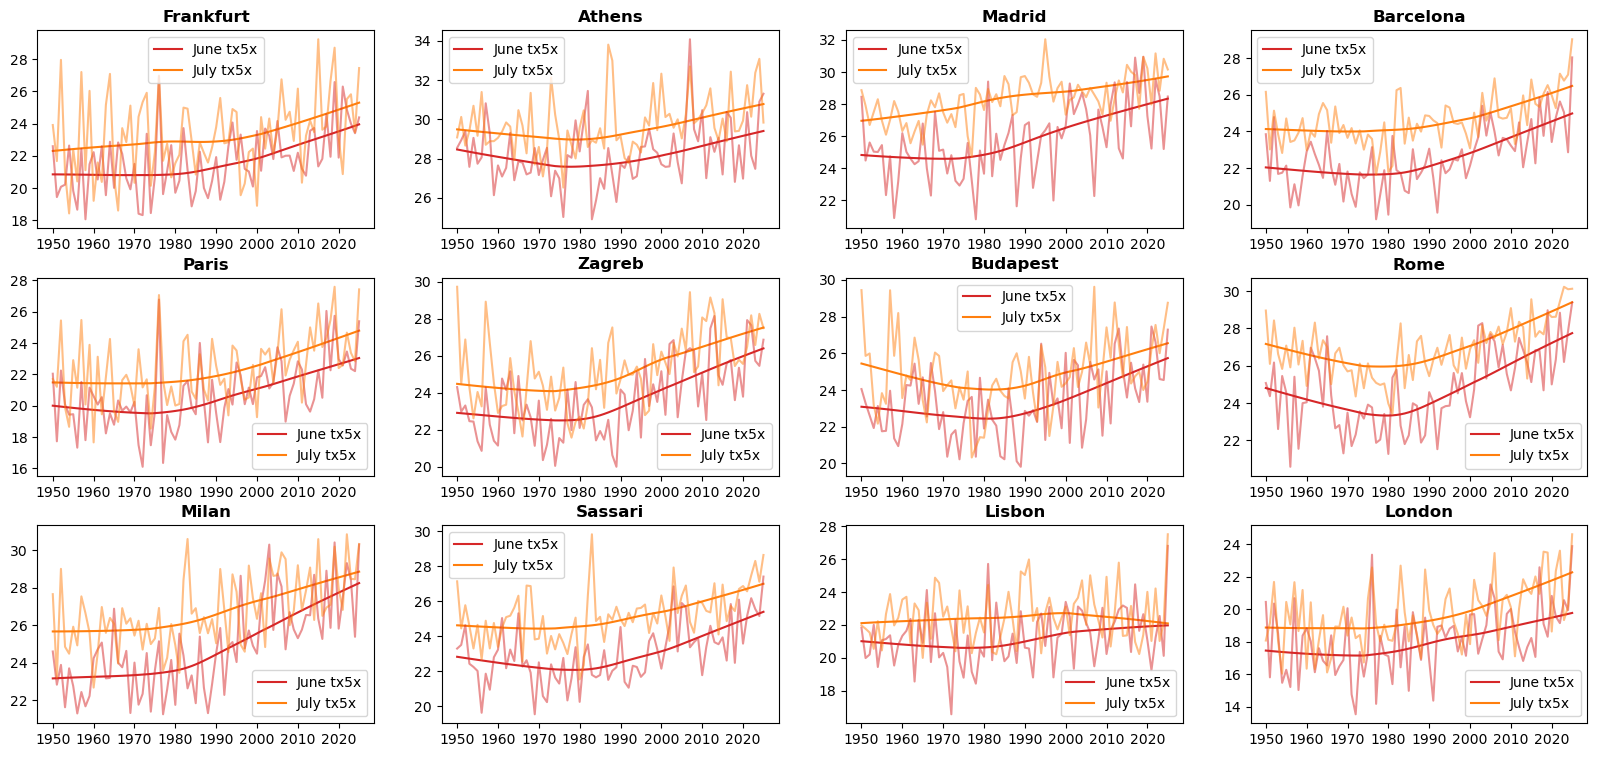

In [24]:
nc = 4; nr = 3
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 5, nr * 3), dpi = 100)
plt.subplots_adjust(hspace = 0.25)

for i in range(min(nc*nr, len(t_cities))):
    c = list(t_cities.keys())[i]
    tx_jun = t_cities[c].rolling(time = 5).mean().groupby("time.month")[6].resample(time = "AS").max()
    tx_jul = t_cities[c].rolling(time = 5).mean().groupby("time.month")[7].resample(time = "AS").max()
    ax = axs.flatten()[i]
       
    ax.plot(tx_jun.time, lowess(tx_jun.values,tx_jun.time)[:,1], label = "June", color = "tab:red")
    ax.plot(tx_jul.time, lowess(tx_jul.values, tx_jul.time)[:,1], label = "July", color = "tab:orange")
    
    ax.plot(tx_jun.time, tx_jun.values, label = "June", color = "tab:red", alpha = 0.5)
    ax.plot(tx_jul.time, tx_jul, label = "July", color = "tab:orange", alpha = 0.5)
    
    ax.set_title(c, fontweight = "bold")
    ax.legend(["June tx5x", "July tx5x"])

In [41]:
gmst = pd.read_table("gmst.txt", comment = "#", sep = " +", engine = "python", header = None, names = ["year", "gmst"], index_col = "year").to_xarray().gmst
gmst = gmst.sel(year = slice(1950,2025))

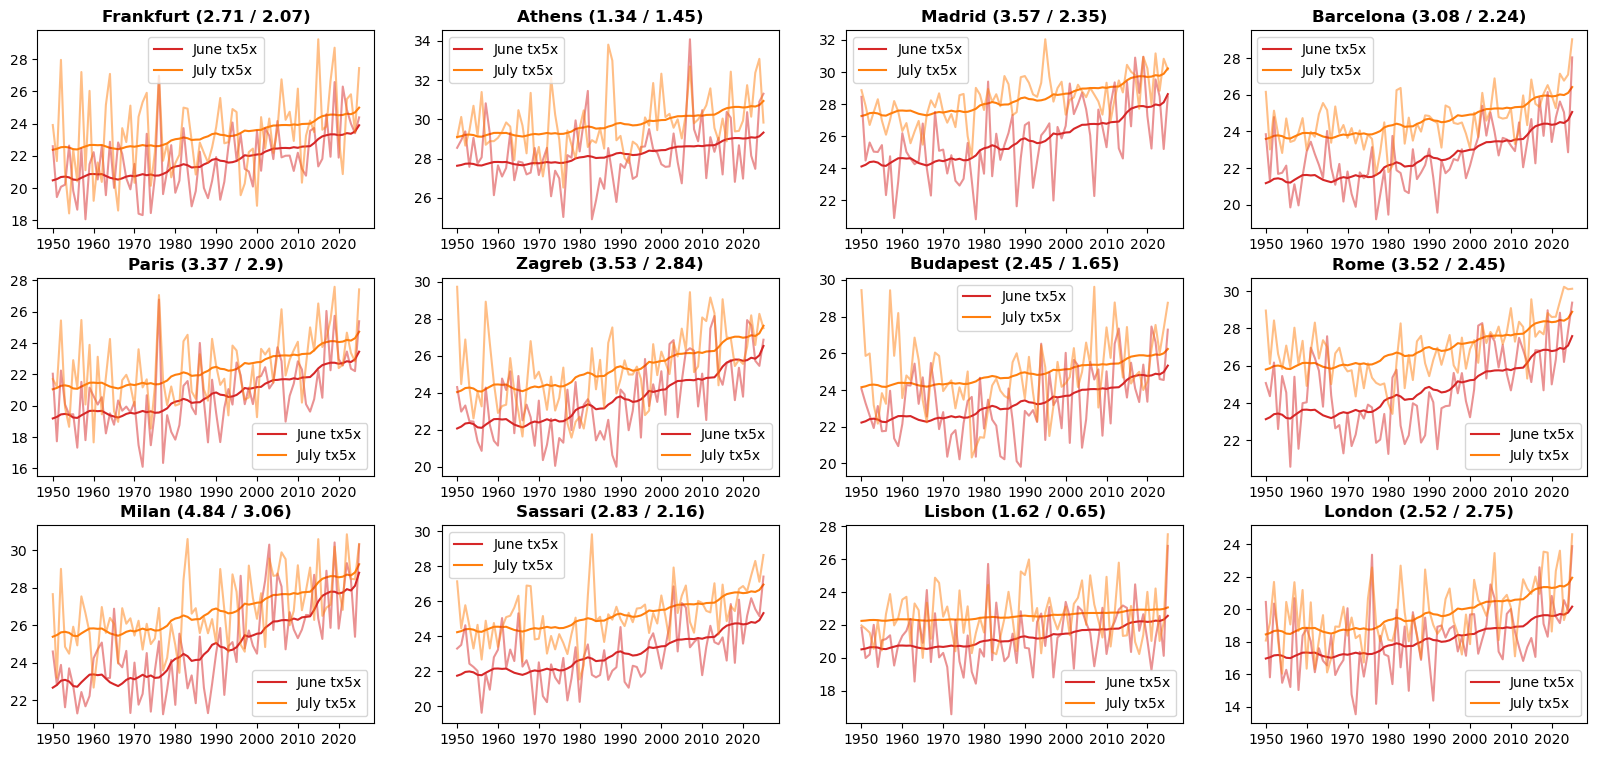

In [51]:
nc = 4; nr = 3
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 5, nr * 3), dpi = 100)
plt.subplots_adjust(hspace = 0.25)

for i in range(min(nc*nr, len(t_cities))):
    c = list(t_cities.keys())[i]
    tx_jun = t_cities[c].rolling(time = 5).mean().groupby("time.month")[6].resample(time = "AS").max()
    tx_jul = t_cities[c].rolling(time = 5).mean().groupby("time.month")[7].resample(time = "AS").max()
    ax = axs.flatten()[i]
    
    coef_jun = tx_jun.assign_coords(time = gmst.values).polyfit("time", deg = 1).polyfit_coefficients
    coef_jul = tx_jul.assign_coords(time = gmst.values).polyfit("time", deg = 1).polyfit_coefficients

    ax.plot(tx_jun.time, xr.polyval(gmst, coef_jun), label = "June", color = "tab:red")
    ax.plot(tx_jul.time, xr.polyval(gmst, coef_jul), label = "July", color = "tab:orange")
    
    ax.plot(tx_jun.time, tx_jun.values, label = "June", color = "tab:red", alpha = 0.5)
    ax.plot(tx_jul.time, tx_jul, label = "July", color = "tab:orange", alpha = 0.5)
    
    ax.set_title(c+" ("+str(coef_jun.sel(degree = 1).round(2).values)+" - "+str(coef_jul.sel(degree = 1).round(2).values)+")", fontweight = "bold")
    ax.legend(["June tx5x", "July tx5x"])

In [63]:
df = merge_byindex([da.to_dataframe().rename(columns = {"t2m" : k}).rolling(5).mean().resample("MS").max() for k, da in t_cities.items()])

In [65]:
df.to_csv("tx5x-monthly_era5_cities.csv")